## Импорты и данные

In [173]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import seaborn as sns
sns.set_theme()

In [174]:
df = pd.read_csv('synthetic_gmv_data_1.2.csv')
df

,user_id,gmv,group_name
0,myo4ixol31,1428,test
1,myo4ixol31,1428,test
2,myo4ixol31,1071,test
3,myo4ixol31,1071,test
4,pkzf2889ww,351,test
...,...,...,...
799056,egoeez9fs9,712,control
799057,egoeez9fs9,641,control
799058,egoeez9fs9,855,control
799059,da9kujvymq,1110,control


In [301]:
data = df.groupby(['user_id', 'group_name'], as_index=False).agg({'gmv': 'sum', 'user_id':'count'})
a = data.loc[data.group_name == 'control']
b = data.loc[data.group_name == 'test']
data

,group_name,gmv,user_id
0,control,733,1
1,test,3187,3
2,control,2933,6
3,test,1695,5
4,control,1496,4
...,...,...,...
196386,test,1141,2
196387,control,2364,4
196388,test,1923,4
196389,control,1235,2


/home/victor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/victor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/victor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/victor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

<Axes: xlabel='gmv', ylabel='Count'>

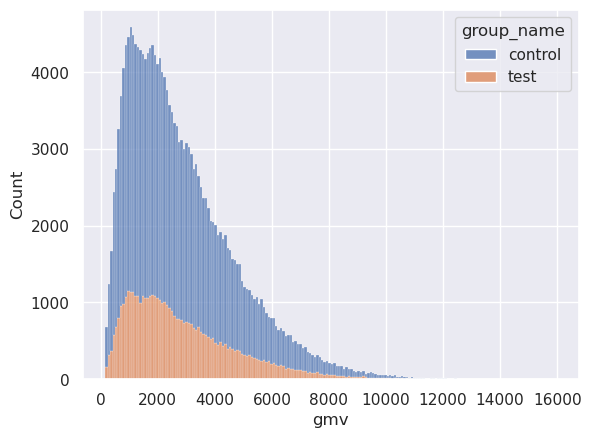

In [302]:
sns.histplot(data=data, x='gmv', hue='group_name', multiple='stack')

In [330]:
def safe_divide(x, y):
    try:
        return x / y
    except ZeroDivisionError:
        return np.nan
    
def delta_var(numerator, denominator):
    x = numerator
    y = denominator
    n = len(x)
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0][1]    
    delta_var = safe_divide(safe_divide(var_x,mu_y**2)  - 2*cov_xy*safe_divide(mu_x,mu_y**3) + var_y*safe_divide(mu_x**2,mu_y**4), n)
    return delta_var

def delta_value(x_num, y_num):
    t_stat, p_value = stats.ttest_ind(x_num, y_num, equal_var=False)
    return t_stat, p_value

def delta_ratio(x_num, x_denom, y_num, y_denom):
    n = len(x_num)
    m = len(y_num)
    test_var = delta_var(x_num, x_denom)
    control_var = delta_var(y_num, y_denom)
    sigma = np.sqrt(test_var + control_var)
    delta_estimator = safe_divide(np.mean(x_num), np.mean(x_denom)) - safe_divide(np.mean(y_num), np.mean(y_denom))
    tt = safe_divide(delta_estimator, sigma)
    p_value = 2*stats.t.sf(np.abs(tt),n+m-2)
    return tt, p_value

# Оценка доверительных интервалов

Уточню, что только за эту задачу у меня нет баллов, поэтому смотрите свозь пальцы

In [332]:
# эти переменные далее изменяться не будут
alpha = 0.05
n = a.gmv.shape[0]
m = b.gmv.shape[0]

## GMV $\delta$ (value)

In [333]:
b.gmv.mean(), b.gmv.mean() 

(2870.650366598778, 2870.650366598778)

In [334]:
test_var = delta_var(a.gmv, np.ones(a.gmv.shape[0]))
control_var = delta_var(b.gmv, np.ones(b.gmv.shape[0]))
sigma = np.sqrt(test_var + control_var)
print(f'Sigma: {round(sigma, 3)}')

delta = b.gmv.mean() - a.gmv.mean() 
print(f'Delta GMV: {(round(delta, 3))}')

l = round(delta - stats.t.ppf(1-alpha/2, n+m-2) * np.sqrt(test_var), 3)
r = round(delta + stats.t.ppf(1-alpha/2, n+m-2) * np.sqrt(test_var), 3)

print(f'CI: [{l}, {r}]')

Sigma: 9.928
Delta GMV: 23.433
CI: [13.79, 33.077]


## GMV $\delta$% (value uplift)

In [335]:
delta = 100 * (b.gmv.mean() - a.gmv.mean()) / a.gmv.mean() 
print(f'Delta GMV%: {round(delta, 3)}%')

l = round(delta - stats.t.ppf(1-alpha/2, n+m-2) * sigma, 3)
r = round(delta + stats.t.ppf(1-alpha/2, n+m-2) * sigma, 3)

print(f'CI: [{l}, {r}]')

Delta GMV%: 0.823%
CI: [-18.635, 20.281]


## AOV $\delta$ (ratio)

AOV - средний чек  
AOV = data.GMV / data.user_id

In [336]:
rt = a.gmv.mean() / a.user_id.mean()
rc = b.gmv.mean() / b.user_id.mean()

print(f'Rc: {round(rc, 3)} \nRt: {round(rt, 3)}')

Rc: 704.206 
Rt: 700.223


/home/victor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/victor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/victor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/victor/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

<Axes: ylabel='Count'>

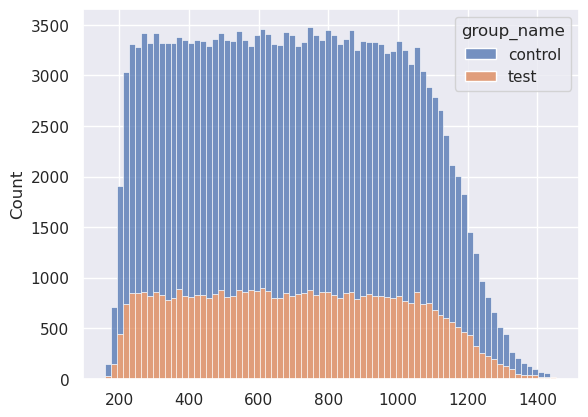

In [326]:
sns.histplot(data=data, x=data.gmv/data.user_id, hue='group_name', multiple='stack')

In [337]:
test_var = delta_var(a.gmv, a.user_id)
control_var = delta_var(b.gmv, b.user_id)
sigma = np.sqrt(test_var + control_var)
print(f'Sigma: {round(sigma, 3)}')

delta = (a.gmv.mean()/a.user_id.mean()) - (b.gmv.mean()/b.user_id.mean())
print(f'Delta AOV: {round(delta, 3)}')

l = round(delta - stats.t.ppf(1-alpha/2, n+m-2) * sigma, 3)
r = round(delta + stats.t.ppf(1-alpha/2, n+m-2) * sigma, 3)

print(f'CI: [{l}, {r}]')

Sigma: 1.699
Delta AOV: -3.982
CI: [-7.313, -0.652]


## AOV $\delta$% (ratio uplift)

In [338]:
delta_percent = 100 * (rt - rc) / (rc)
print(f'Delta AOV%: {round(delta_percent, 3)}%')

l = round(delta_percent - stats.t.ppf(1-alpha/2, n+m-2) * sigma, 3)
r = round(delta_percent + stats.t.ppf(1-alpha/2, n+m-2) * sigma, 3)

print(f'CI: [{l}, {r}]')

Delta AOV%: -0.566%
CI: [-3.896, 2.765]
